In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# split
from sklearn.model_selection import train_test_split

# column transformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Preprocessing

# encoding
from sklearn.preprocessing import OneHotEncoder,KBinsDiscretizer
from category_encoders import OrdinalEncoder
from category_encoders import BinaryEncoder 

# scaling
from sklearn.preprocessing import RobustScaler

# Resampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

# Cross Validation
from sklearn.model_selection import StratifiedKFold,cross_val_score, cross_validate

# model Classification
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier         # Untuk Random Forest
from xgboost import XGBClassifier                           # Untuk XGBoost    
import pickle

# scoring classification
from sklearn.metrics import  f1_score, precision_score, recall_score, precision_recall_curve, classification_report, confusion_matrix, RocCurveDisplay

In [3]:
df = pd.read_csv('../DataSet/bank-additional-full_cleaned.csv',sep=',')

In [4]:
df.duplicated().sum()

np.int64(10)

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df['y'] = df['y'].map({'no': 0, 'yes': 1}).astype(int)

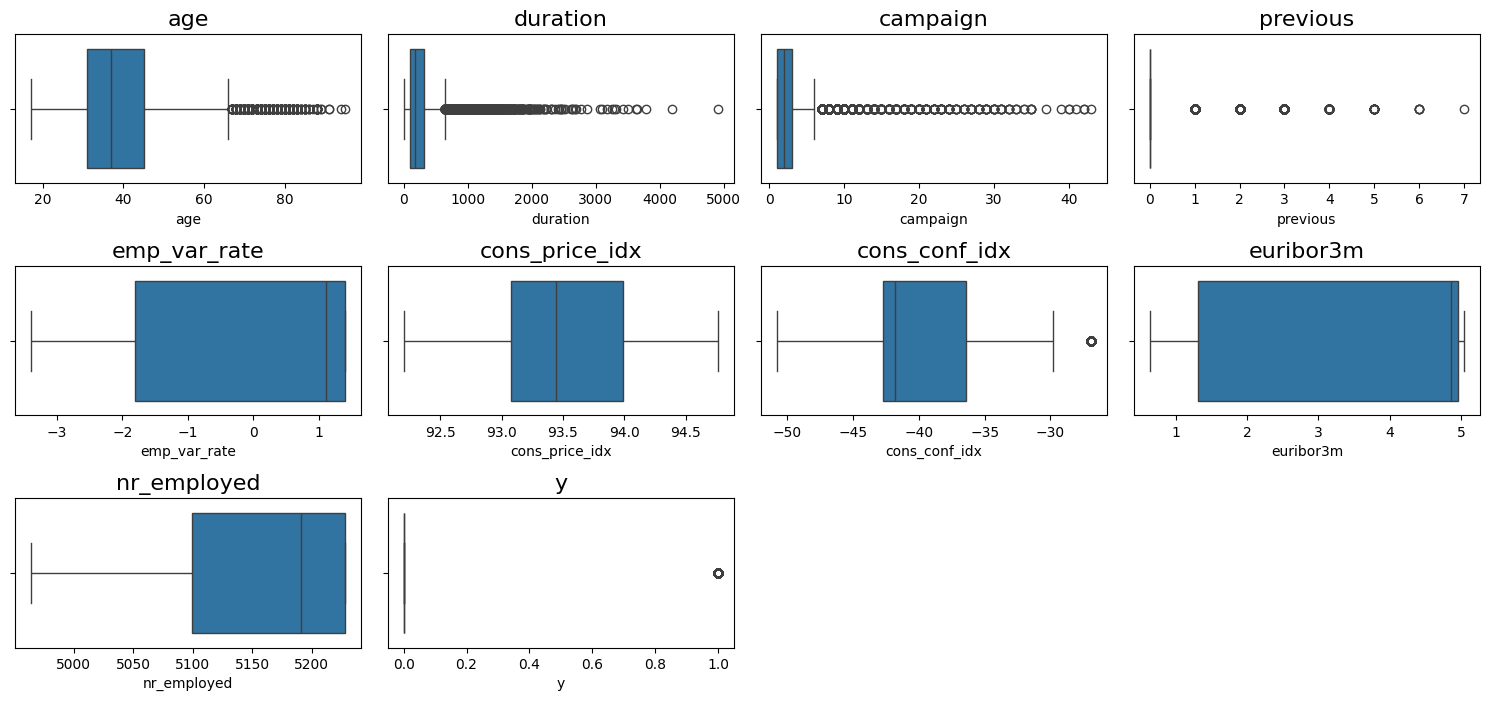

In [7]:
# Outlier Check
num_feature = df.describe().columns
plt.figure(figsize=(15, 9), facecolor='white')
plotnumber = 1
    
for feature in num_feature:
    ax = plt.subplot(4,4, plotnumber)
    sns.boxplot(x=feature, data=df);
    plt.title(feature, fontsize=16)
    plt.tight_layout()
    plotnumber = plotnumber + 1

## **Data Preprocessing**

In [8]:
ordinal_mapping = [
    {
        'col': 'education',
        'mapping': {'illiterate': 1, 'basic.4y': 2, 'basic.6y': 3, 'basic.9y': 4, 'high.school':5, 'professional.course':6, 'university.degree': 7}
    }
]

This process aims to perform ordinal encoding on the education feature by assigning numerical values based on the level of education. This allows the machine learning model to understand the hierarchical relationship between categories — for example, that university.degree represents a higher level than high.school.

Encoding Feature: 
- **Robust Scaler :**  `age`,`campaign`, `emp_var_rate`, `cons_price_idx`, `cons_conf_idx`, `euribor3m`, `nr_employed`,`duration`
- **Onehot Encoder :**  `marital`, `default`, `housing`, `loan`, `contact`, `poutcome`.
- **Binary Encoder:**  `job`, `month`, `day_of_week`
- **Ordinal Encoder:**  `education`,

In [9]:
transformer = ColumnTransformer([
    # Ordinal encoding
    ("ordinal", OrdinalEncoder(cols=["education"], mapping=ordinal_mapping), ["education"]),

    # One-hot encoding
    ("onehot", OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), 
     [ "marital", "default", "housing", "loan", "contact", "poutcome"]),

    # binary encoding
    ("binary", BinaryEncoder(), 
     ["job", "month", "day_of_week"]),

    # Scaling
    ("scaler", RobustScaler(), ["age","campaign", "emp_var_rate", "cons_price_idx", 
                                "cons_conf_idx", "euribor3m", "nr_employed","duration"])
], remainder='passthrough', verbose_feature_names_out=False)

In [10]:
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinal',
                                 OrdinalEncoder(cols=['education'],
                                                mapping=[{'col': 'education',
                                                          'data_type': dtype('O'),
                                                          'mapping': illiterate             1
basic.4y               2
basic.6y               3
basic.9y               4
high.school            5
professional.course    6
university.degree      7
dtype: int64}]),
                                 ['education']),
                                ('onehot',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['marital', 'default', 'housing', 'loan',
                                  'contact', 'poutcome']),
                                ('binary', BinaryEncoder(),
                                 ['job', 'month', 'day_of_week']),
                                ('scaler', RobustScaler(),
                                 ['age', 'campaign', 'emp_var_rate',
                                  'cons_price_idx', 'cons_conf_idx',
                                  'euribor3m', 'nr_employed', 'duration'])],
                  verbose_feature_names_out=False)

## **Modelling and Evaluation**

In [11]:
# Define X and y
X = df.drop(columns=['y'])
y = df['y']

In [12]:
# Data Splitting
X_train, X_test, y_train, y_test = train_test_split( 
    X, 
    y, 
    test_size=0.2,  
    random_state=42, 
    stratify=y
)

In [13]:
# Check target proportion
df['y'].value_counts()/len(df['y']) * 100

y
0    87.341689
1    12.658311
Name: count, dtype: float64

In [14]:
sampling_strategies = {
    'none': None,
    'smote': SMOTE(random_state=42),
    'under_sampling': RandomUnderSampler(random_state=42),
    'smote_tomek': SMOTETomek(random_state=42)
}

### **Cross Validation and Check Perfomance to Data Test**


This process aims to evaluate the model's performance using cross-validation on the training data while also assessing the final model's performance on previously unseen test data. Cross-validation provides a more reliable performance estimate by splitting the training data into multiple folds, while evaluation on the test data measures the model's real-world generalization. Metrics used include precision as well as business metrics such as CVR and ROMI.

Several classification algorithms were prepared for evaluation and performance comparison, including linear models and tree-based models. Each model was initialized with default parameters, and random_state was set to ensure reproducibility. The models used include:

**Logistic Regression**: Selected as the baseline model due to its high interpretability and fast training. Suitable for understanding the linear influence of features on the probability of deposit subscription.

**K-Nearest Neighbors (KNN)**: Considered to evaluate a similarity-based approach between customers. Although less efficient for large datasets, KNN serves as a useful non-parametric benchmark.

**Decision Tree**: A model that is easy to interpret and can handle categorical features without extensive preprocessing. Useful for explicitly exploring non-linear relationships.

**Random Forest**: An ensemble of trees that improves accuracy and robustness against overfitting compared to a single tree. Effectively handles complex feature interactions.

**XGBoost**: Chosen for its outstanding performance in various competitions and real-world cases. Capable of handling class imbalance and often delivers high precision and CVR.

These models will be used in the cross-validation process to identify the best candidate before performing further hyperparameter tuning.

In [15]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42),
}

In [16]:
# Constants
COST_PER_CALL = 23 
REVENUE_PER_CONVERSION = 500  

def calc_cvr(y_true, y_pred):
    TP = sum((y_true == 1) & (y_pred == 1))
    FP = sum((y_true == 0) & (y_pred == 1))
    if TP + FP == 0:
        return 0.0
    return (TP / (TP + FP)) * 100

def calc_romi(y_true, y_pred):
    TP = sum((y_true == 1) & (y_pred == 1))
    FP = sum((y_true == 0) & (y_pred == 1))
    total_revenue = TP * REVENUE_PER_CONVERSION
    total_cost = (TP + FP) * COST_PER_CALL
    if total_cost == 0:
        return 0.0
    return ((total_revenue - total_cost) / total_cost) * 100

# Cross-validation setup
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {  
    'precision': 'precision',
}

results_all_models = []

print("Testing preprocessor...")
try:
    X_sample = X_train.head(100)
    X_transformed = transformer.fit_transform(X_sample, y_train.head(100))
    print(f"\u2713 Transformer works! Transformed shape: {X_transformed.shape}")
except Exception as e:
    print(f"\u2717 Transformer error: {e}")
    import traceback
    traceback.print_exc()

print(f"\nDataset info:")
print(f"Training set shape: {X_train.shape}")
print(f"Target distribution:\n{y_train.value_counts()}")
print(f"Target distribution (%):\n{y_train.value_counts(normalize=True).round(4)}")

for sampling_name, sampling_strategy in sampling_strategies.items():
    print(f"\n{'='*60}")
    print(f"SAMPLING STRATEGY: {sampling_name.upper()}")
    print(f"{'='*60}")

    for model_name, model in models.items():
        print(f"\nEvaluating {model_name} with {sampling_name}...")

        if sampling_strategy is None:
            pipeline = Pipeline([
                ("preprocessing", transformer),
                ("modeling", model)
            ])
        else:
            pipeline = ImbPipeline([
                ("preprocessing", transformer),
                ("sampling", sampling_strategy),
                ("modeling", model)
            ])

        try:
            X_sample = X_train.head(200)
            y_sample = y_train.head(200)
            pipeline.fit(X_sample, y_sample)
            print(f"  \u2713 Pipeline fit successful")

            cv_results = cross_validate(
                estimator=pipeline,
                X=X_train,
                y=y_train,
                cv=cv_folds,
                scoring=scoring,
                return_train_score=True,
                n_jobs=1
            )

            # Predict test set
            y_pred = pipeline.predict(X_test)
            cvr = calc_cvr(y_test, y_pred)
            romi = calc_romi(y_test, y_pred)

            result = {
                'Sampling': sampling_name,
                'Model': model_name,
                'Train_Precision': cv_results['train_precision'].mean().round(4),
                'Test_Precision': cv_results['test_precision'].mean().round(4),
                'CVR': round(cvr, 2),
                'ROMI': round(romi, 2)
            }
            results_all_models.append(result)

            print(f"  \u2713 {model_name} completed successfully")
            print(f"    - Test Precision: {result['Test_Precision']}")
            print(f"    - CVR: {result['CVR']}%")
            print(f"    - ROMI: {result['ROMI']}%")

        except Exception as e:
            print(f"  \u2717 Error with {model_name}: {str(e)}")
            import traceback
            traceback.print_exc()

            result = {
                'Sampling': sampling_name,
                'Model': model_name,
                'Train_Precision': 0.0,
                'Test_Precision': 0.0,
                'CVR': 0.0,
                'ROMI': 0.0
            }
            results_all_models.append(result)

if results_all_models:
    df_cv_results = pd.DataFrame(results_all_models)
    print("\n" + "=" * 100)
    print("CROSS-VALIDATION RESULTS - ALL COMBINATIONS")
    print("=" * 100)
    print(df_cv_results.to_string(index=False))
else:
    print("No results to display - all models failed.")


Testing preprocessor...
✓ Transformer works! Transformed shape: (100, 28)

Dataset info:
Training set shape: (24382, 19)
Target distribution:
y
0    21296
1     3086
Name: count, dtype: int64
Target distribution (%):
y
0    0.8734
1    0.1266
Name: proportion, dtype: float64

SAMPLING STRATEGY: NONE

Evaluating Logistic Regression with none...
  ✓ Pipeline fit successful


/Users/stefanus.admaja/Desktop/Development/Python/bank-telemarketing-predictive-model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/stefanus.admaja/Desktop/Development/Python/bank-telemarketing-predictive-model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please a

  ✓ Logistic Regression completed successfully
    - Test Precision: 0.6704
    - CVR: 49.73%
    - ROMI: 981.12%

Evaluating K-Nearest Neighbors with none...
  ✓ Pipeline fit successful
  ✓ K-Nearest Neighbors completed successfully
    - Test Precision: 0.5881
    - CVR: 53.02%
    - ROMI: 1052.52%

Evaluating Decision Tree with none...
  ✓ Pipeline fit successful
  ✓ Decision Tree completed successfully
    - Test Precision: 0.5133
    - CVR: 45.83%
    - ROMI: 896.38%

Evaluating Random Forest with none...
  ✓ Pipeline fit successful
  ✓ Random Forest completed successfully
    - Test Precision: 0.6598
    - CVR: 53.4%
    - ROMI: 1060.96%

Evaluating XGBoost with none...
  ✓ Pipeline fit successful
  ✓ XGBoost completed successfully
    - Test Precision: 0.6361
    - CVR: 53.02%
    - ROMI: 1052.64%

SAMPLING STRATEGY: SMOTE

Evaluating Logistic Regression with smote...
  ✓ Pipeline fit successful


/Users/stefanus.admaja/Desktop/Development/Python/bank-telemarketing-predictive-model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/stefanus.admaja/Desktop/Development/Python/bank-telemarketing-predictive-model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please a

  ✓ Logistic Regression completed successfully
    - Test Precision: 0.4664
    - CVR: 35.97%
    - ROMI: 681.96%

Evaluating K-Nearest Neighbors with smote...
  ✓ Pipeline fit successful
  ✓ K-Nearest Neighbors completed successfully
    - Test Precision: 0.4323
    - CVR: 33.37%
    - ROMI: 625.52%

Evaluating Decision Tree with smote...
  ✓ Pipeline fit successful
  ✓ Decision Tree completed successfully
    - Test Precision: 0.5018
    - CVR: 43.25%
    - ROMI: 840.22%

Evaluating Random Forest with smote...
  ✓ Pipeline fit successful
  ✓ Random Forest completed successfully
    - Test Precision: 0.6083
    - CVR: 45.51%
    - ROMI: 889.31%

Evaluating XGBoost with smote...
  ✓ Pipeline fit successful
  ✓ XGBoost completed successfully
    - Test Precision: 0.621
    - CVR: 44.59%
    - ROMI: 869.28%

SAMPLING STRATEGY: UNDER_SAMPLING

Evaluating Logistic Regression with under_sampling...
  ✓ Pipeline fit successful


/Users/stefanus.admaja/Desktop/Development/Python/bank-telemarketing-predictive-model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  ✓ Logistic Regression completed successfully
    - Test Precision: 0.4564
    - CVR: 38.67%
    - ROMI: 740.7%

Evaluating K-Nearest Neighbors with under_sampling...
  ✓ Pipeline fit successful
  ✓ K-Nearest Neighbors completed successfully
    - Test Precision: 0.4228
    - CVR: 38.25%
    - ROMI: 731.56%

Evaluating Decision Tree with under_sampling...
  ✓ Pipeline fit successful
  ✓ Decision Tree completed successfully
    - Test Precision: 0.4167
    - CVR: 41.4%
    - ROMI: 799.99%

Evaluating Random Forest with under_sampling...
  ✓ Pipeline fit successful
  ✓ Random Forest completed successfully
    - Test Precision: 0.4447
    - CVR: 33.48%
    - ROMI: 627.85%

Evaluating XGBoost with under_sampling...
  ✓ Pipeline fit successful
  ✓ XGBoost completed successfully
    - Test Precision: 0.4567
    - CVR: 34.3%
    - ROMI: 645.75%

SAMPLING STRATEGY: SMOTE_TOMEK

Evaluating Logistic Regression with smote_tomek...
  ✓ Pipeline fit successful


/Users/stefanus.admaja/Desktop/Development/Python/bank-telemarketing-predictive-model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/stefanus.admaja/Desktop/Development/Python/bank-telemarketing-predictive-model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please a

  ✓ Logistic Regression completed successfully
    - Test Precision: 0.4665
    - CVR: 37.19%
    - ROMI: 708.52%

Evaluating K-Nearest Neighbors with smote_tomek...
  ✓ Pipeline fit successful
  ✓ K-Nearest Neighbors completed successfully
    - Test Precision: 0.4327
    - CVR: 33.37%
    - ROMI: 625.52%

Evaluating Decision Tree with smote_tomek...
  ✓ Pipeline fit successful
  ✓ Decision Tree completed successfully
    - Test Precision: 0.5043
    - CVR: 44.42%
    - ROMI: 865.62%

Evaluating Random Forest with smote_tomek...
  ✓ Pipeline fit successful
  ✓ Random Forest completed successfully
    - Test Precision: 0.6099
    - CVR: 48.21%
    - ROMI: 948.08%

Evaluating XGBoost with smote_tomek...
  ✓ Pipeline fit successful
  ✓ XGBoost completed successfully
    - Test Precision: 0.626
    - CVR: 45.85%
    - ROMI: 896.77%

CROSS-VALIDATION RESULTS - ALL COMBINATIONS
      Sampling               Model  Train_Precision  Test_Precision   CVR    ROMI
          none Logistic Regressi

### **Hyperparameter Tuning**

This process aims to optimize model performance by finding the best combination of hyperparameters using **GridSearchCV**. By performing a grid search over various values such as the number of estimators, tree depth, learning rate, and subsampling parameters (specifically for XGBoost), the model can be fine-tuned to achieve the best performance, particularly in terms of precision. This aligns with the business focus on minimizing false positives and improving marketing efficiency. The evaluation is conducted using stratified cross-validation to maintain class proportions in each fold.


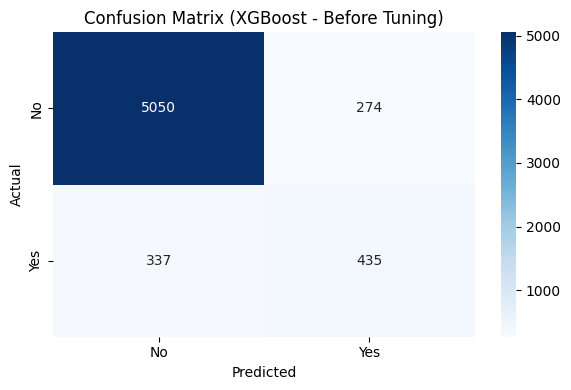


Classification Report (XGBoost - Before Tuning):
              precision    recall  f1-score   support

          No       0.94      0.95      0.94      5324
         Yes       0.61      0.56      0.59       772

    accuracy                           0.90      6096
   macro avg       0.78      0.76      0.77      6096
weighted avg       0.90      0.90      0.90      6096

Precision (XGBoost - Before Tuning): 0.6135
CVR (XGBoost - Before Tuning): 61.35%
ROMI (XGBoost - Before Tuning): 1233.78%


In [ ]:
# Baseline XGBoost model (without tuning)
xgb_base = XGBClassifier(random_state=42)

# Pipeline
baseline_xgb_pipeline = Pipeline([
    ("preprocessing", transformer),
    ("modeling", xgb_base)
])

# Fit
baseline_xgb_pipeline.fit(X_train, y_train)

# Predict
y_pred_xgb_before = baseline_xgb_pipeline.predict(X_test)

# Confusion Matrix
cm_xgb_before = confusion_matrix(y_test, y_pred_xgb_before)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb_before, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (XGBoost - Before Tuning)')
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report (XGBoost - Before Tuning):")
print(classification_report(y_test, y_pred_xgb_before, target_names=['No', 'Yes']))

# Precision
precision_xgb_before = precision_score(y_test, y_pred_xgb_before)
print(f"Precision (XGBoost - Before Tuning): {precision_xgb_before:.4f}")

# Addition: CVR dan ROMI
cvr_xgb_before = calc_cvr(y_test, y_pred_xgb_before)
romi_xgb_before = calc_romi(y_test, y_pred_xgb_before)
print(f"CVR (XGBoost - Before Tuning): {cvr_xgb_before:.2f}%")
print(f"ROMI (XGBoost - Before Tuning): {romi_xgb_before:.2f}%")

In [18]:
# Base Model 
xgb_model = XGBClassifier(random_state=42)

# Pipeline
xgb_pipeline = Pipeline([
    ("preprocessing", transformer),
    ("modeling", xgb_model)
])

# Hyperparameter grid
hyperparam_xgb = {
    'modeling__n_estimators': [100, 200],
    'modeling__max_depth': [3, 5],
    'modeling__learning_rate': [0.01, 0.1],
    'modeling__subsample': [0.8, 1],
    'modeling__colsample_bytree': [0.8, 1]
}

# GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=hyperparam_xgb,
    scoring='precision',
    n_jobs=-1,
    cv=cv_folds,
    verbose=1
)

# Fit
grid_search_xgb.fit(X_train, y_train)

# Best Model 
best_xgb_model = grid_search_xgb.best_estimator_
print("\nBest Parameters Found (XGBoost):")
print(grid_search_xgb.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best Parameters Found (XGBoost):
{'modeling__colsample_bytree': 0.8, 'modeling__learning_rate': 0.01, 'modeling__max_depth': 3, 'modeling__n_estimators': 100, 'modeling__subsample': 0.8}


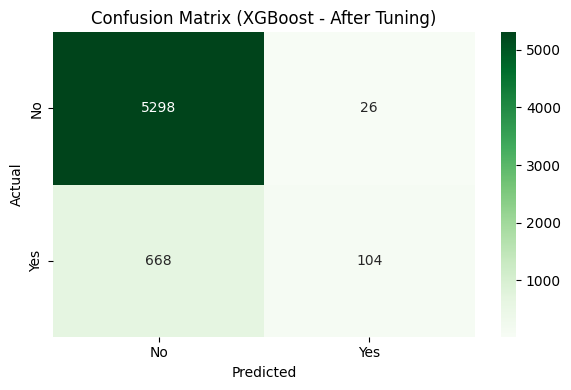


 Classification Report (XGBoost - After Tuning):
              precision    recall  f1-score   support

          No       0.89      1.00      0.94      5324
         Yes       0.80      0.13      0.23       772

    accuracy                           0.89      6096
   macro avg       0.84      0.56      0.58      6096
weighted avg       0.88      0.89      0.85      6096

Precision (XGBoost - After Tuning): 0.8000
CVR (XGBoost - After Tuning): 80.00%
ROMI (XGBoost - After Tuning): 1639.13%


In [19]:
# Prediction
y_pred_xgb_after = best_xgb_model.predict(X_test)

# Confusion Matrix
cm_xgb_after = confusion_matrix(y_test, y_pred_xgb_after)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb_after, annot=True, fmt='d', cmap='Greens', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (XGBoost - After Tuning)')
plt.tight_layout()
plt.show()

# Classification Report
print("\n Classification Report (XGBoost - After Tuning):")
print(classification_report(y_test, y_pred_xgb_after, target_names=['No', 'Yes']))

# Precision
precision_xgb_after = precision_score(y_test, y_pred_xgb_after)
print(f"Precision (XGBoost - After Tuning): {precision_xgb_after:.4f}")

cvr_xgb_after = calc_cvr(y_test, y_pred_xgb_after)
romi_xgb_after = calc_romi(y_test, y_pred_xgb_after)
print(f"CVR (XGBoost - After Tuning): {cvr_xgb_after:.2f}%")
print(f"ROMI (XGBoost - After Tuning): {romi_xgb_after:.2f}%")

### **Threshold Tuning**

After the best model is identified through hyperparameter tuning, a subsequent process called threshold tuning is performed to adjust the probability threshold for classification, aiming to maximize precision according to business priorities. This process evaluates model performance across various threshold values and calculates metrics such as Precision, Recall, F1 Score, CVR, and ROMI.



=== Threshold Evaluation with CVR & ROMI ===
    Threshold  Precision  Recall  F1_Score  CVR (%)  ROMI (%)
0        0.10     0.3429  0.9573    0.5050    34.29    645.49
1        0.15     0.4601  0.8821    0.6048    46.01    900.29
2        0.20     0.5090  0.8096    0.6250    50.90   1006.43
3        0.25     0.5467  0.6969    0.6128    54.67   1088.58
4        0.30     0.5796  0.6036    0.5914    57.96   1160.00
5        0.35     0.6462  0.4093    0.5012    64.62   1304.82
6        0.40     0.6986  0.2552    0.3738    69.86   1418.66
7        0.45     0.7610  0.1567    0.2599    76.10   1554.36
8        0.50     0.8000  0.1347    0.2306    80.00   1639.13
9        0.55     0.8406  0.0751    0.1379    84.06   1727.35
10       0.60     0.0000  0.0000    0.0000     0.00      0.00
11       0.65     0.0000  0.0000    0.0000     0.00      0.00
12       0.70     0.0000  0.0000    0.0000     0.00      0.00
13       0.75     0.0000  0.0000    0.0000     0.00      0.00
14       0.80     0.0000

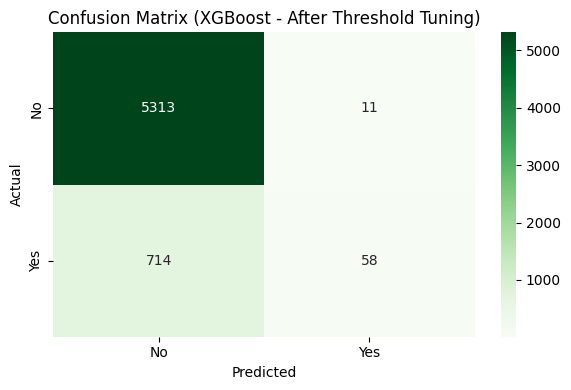

In [20]:
y_proba = best_xgb_model.predict_proba(X_test)[:, 1]

# Parameter Business
cost_per_customer = 23
revenue_per_success = 500

# Loop 
thresholds = np.arange(0.1, 0.91, 0.05)
metrics_list = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # CVR: dari semua prediksi positif, berapa yang benar (true positive)
    tp = np.sum((y_test == 1) & (y_pred == 1))
    pred_pos = np.sum(y_pred == 1)
    cvr = (tp / pred_pos) * 100 if pred_pos > 0 else 0
    
    # ROMI: (Revenue - Cost) / Cost * 100
    total_revenue = tp * revenue_per_success
    total_cost = pred_pos * cost_per_customer
    romi = ((total_revenue - total_cost) / total_cost) * 100 if total_cost > 0 else 0

    metrics_list.append({
        'Threshold': t,
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1_Score': round(f1, 4),
        'CVR (%)': round(cvr, 2),
        'ROMI (%)': round(romi, 2)
    })

# Result in DataFrame
df_threshold = pd.DataFrame(metrics_list)
print("\n=== Threshold Evaluation with CVR & ROMI ===")
print(df_threshold)

# Take threshold with highest precision 
best_row = df_threshold.sort_values(by='Precision', ascending=False).iloc[0]
best_threshold = best_row['Threshold']
print(f"\n Best Threshold (Highest Precision): {best_threshold}")
print(best_row)

# Confusion Matrix end
y_pred_best = (y_proba >= best_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=True,
            xticklabels=['No', 'Yes'],
            yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (XGBoost - After Threshold Tuning)')
plt.tight_layout()
plt.show()


## **Save Model**

In [21]:
import pickle

# Simpan model ke file
with open('best_xgb_model.pkl', 'wb') as f:
    pickle.dump(best_xgb_model, f)

# Simpan threshold terbaik juga (jika ada threshold tuning)
with open('best_threshold.pkl', 'wb') as f:
    pickle.dump(best_threshold, f)
